In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
from utils import (
    process_features,
    get_significant_variables,
    plot_feature_weights_horizontal_sm,
)
import statsmodels.api as sm

In [223]:
DATA_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/data")

cols_of_interest = [
    "condition_name",
    "number_of_readmissions",
    "number_of_discharges",
    "beneficiary_avg_age",
    "pct_beneficiaries_female",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_alzheimers",
    "pct_beneficiaries_congestive_heart_failure",
    "pct_beneficiaries_ischemic_heart_disease",
    "pct_beneficiaries_copd",
    "pct_beneficiaries_depression",
    "pct_beneficiaries_diabetes",
    "pct_beneficiaries_arthritis",
    "pct_beneficiaries_psychotic_disorders",
    "pct_beneficiaries_stroke",
    "pct_beneficiaries_white",
    "pct_beneficiaries_black",
    "pct_beneficiaries_hispanic",
    "pct_beneficiaries_medicare_medicaid",
    # "pct_beneficiaries_afib",
    # "pct_beneficiaries_osteoporosis",
    # "pct_beneficiaries_chronic_kidney_disease",
    # "pct_beneficiaries_cancer",
]
df = pd.read_csv(
    (DATA_PATH / "obt_slimmer.csv"),
    usecols=cols_of_interest,
)

### drop nans
df.dropna(inplace=True)

### remove 'beneficiaries_' from col names
df.columns = df.columns.str.replace("beneficiaries_", "")

### Calculate new columns
df["readmission_rate"] = (
    df["number_of_readmissions"] / df["number_of_discharges"]
) * 100
df["pct_non_white"] = 1 - df["pct_white"]


### Condition Query
condition = "pn"  ###### ENTER NAME HERE #####
if condition == "hf":
    df = df.query("condition_name == 'Heart Failure'")
elif condition == "copd":
    df = df.query("condition_name == 'Chronic Obstructive Pulmonary Disease'")
elif condition == "pn":
    df = df.query("condition_name == 'Pneumonia'")

### Drop extra columns
df.drop(
    columns=[
        "number_of_readmissions",
        "number_of_discharges",
        "pct_white",
        "condition_name",
    ],
    inplace=True,
)

### Transform Data
# log_transform = [
#     "pct_psychotic_disorders",
#     "pct_black",
#     "pct_hispanic",
#     "pct_non_white",
#     "pct_medicare_medicaid",
# ]

# for col in df.columns:
#     if col in log_transform:
#         df[col] = np.log10(df[col])

### SAVE OUT DMS
DM_PATH = Path("/Users/jessbreda/Desktop/github/ca-sdoh/code/jess/design_matrices")

# y
y = df["readmission_rate"]
y.reset_index(drop=True, inplace=True)
y.to_csv(DM_PATH / f"{condition}_y.csv", index=False)

# X
X = df.drop(columns=["readmission_rate"])
X.reset_index(drop=True, inplace=True)

X_race_1 = X.drop(columns=["pct_black", "pct_hispanic"])
X_race_2 = X.drop(columns=["pct_non_white"])
X_base = X.drop(columns=["pct_non_white", "pct_black", "pct_hispanic"])

X_race_1.to_csv(DM_PATH / f"{condition}_X_race1.csv", index=False)
X_race_2.to_csv(DM_PATH / f"{condition}_X_race2.csv", index=False)
X_base.to_csv(DM_PATH / f"{condition}_X_base.csv", index=False)

In [210]:
### READ IN
y = pd.read_csv(DM_PATH / f"{condition}_y.csv", index_col=False)
y = y.squeeze()

X_race_1 = pd.read_csv(DM_PATH / f"{condition}_X_race1.csv")
X_race_2 = pd.read_csv(DM_PATH / f"{condition}_X_race2.csv")
X_base_2 = pd.read_csv(DM_PATH / f"{condition}_X_base.csv")

In [218]:
# Linear Model
usdf = X_race_2
X_standardized = process_features(
    usdf,
    numeric_cols=usdf.columns,
)
X_standardized.reset_index(drop=True, inplace=True)
X_standardized_w_bias = sm.add_constant(X_standardized)
# X_standardized_w_bias = sm.add_constant(X_standardized)
# X_hf_race_1 = X_standardized_w_bias.drop(columns=["pct_non_white"])

linear_model = sm.OLS(y, X_standardized_w_bias)
linear_model = linear_model.fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       readmission_rate   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.231
Method:                 Least Squares   F-statistic:                     44.20
Date:                Fri, 21 Jul 2023   Prob (F-statistic):           5.17e-99
Time:                        11:58:46   Log-Likelihood:                -4699.4
No. Observations:                1872   AIC:                             9427.
Df Residuals:                    1858   BIC:                             9504.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           17.2551      0.069    249.710      0.000      17.120      17.391
beneficiary_avg_age             -0.7844      0.117     -6.710      0.000      -1.014      -0.555
pct_female                       0.2555      0.094      2.722      0.007       0.071       0.440
pct_medicare_medicaid            0.4927      0.139      3.549      0.000       0.220       0.765
pct_alzheimers                   0.4264      0.167      2.558      0.011       0.100       0.753
pct_congestive_heart_failure    -0.2301      0.121     -1.900      0.058      -0.468       0.007
pct_copd                         0.1343      0.113      1.185      0.236      -0.088       0.356
pct_depression                  -0.5186      0.125     -4.147      0.000      -0.764      -0.273
pct_diabetes                     0.1499      0.164      0.914      0.361      -0.172       0.472
pct_ischemic_heart_disease       0.4878      0.113      4.312      0.000       0.266       0.710
pct_arthritis                    0.3160      0.089      3.553      0.000       0.142       0.490
pct_psychotic_disorders          0.4182      0.145      2.891      0.004       0.135       0.702
pct_stroke                       0.4043      0.090      4.517      0.000       0.229       0.580
pct_non_white                   -0.0582      0.166     -0.350      0.727      -0.385       0.268
==============================================================================
Omnibus:                       26.797   Durbin-Watson:                   1.840
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               32.732
Skew:                           0.211   Prob(JB):                     7.80e-08
Kurtosis:                       3.492   Cond. No.                         7.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

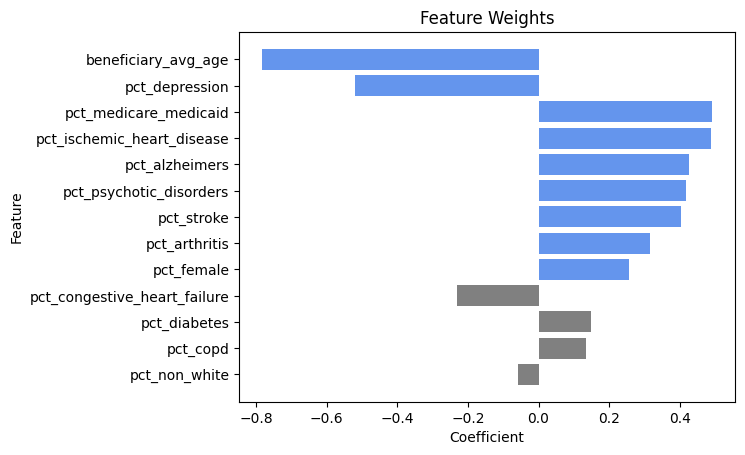

In [219]:
plot_feature_weights_horizontal_sm(linear_model)

Text(0.5, 1.0, 'Feature Weights without Log Transformed Variables')

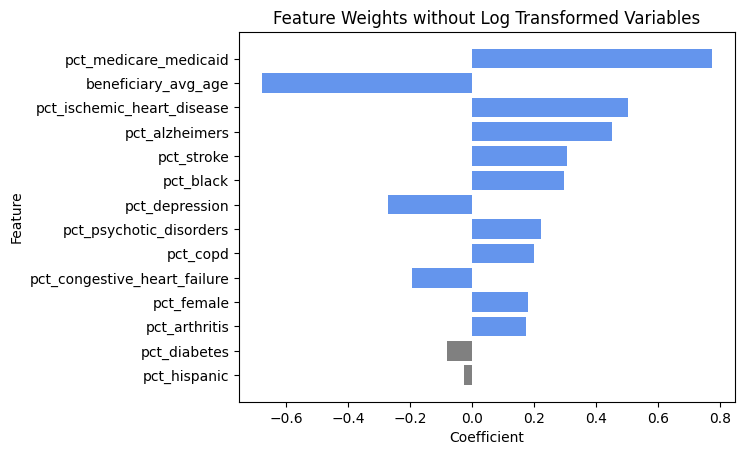

In [87]:
feature_names = linear_model.params.index[1:]  # Exclude the bias term
coefficients = linear_model.params[1:]

re_transformed_coefficeints = []
for fn in feature_names:
    if fn in log_transform:
        re_transformed_coefficeints.append(np.power(10, coefficients[fn]))
    else:
        re_transformed_coefficeints.append(coefficients[fn])
re_transformed_coefficeints = np.array(re_transformed_coefficeints)

# # Sort feature names and coefficients based on absolute coefficient values
sorted_indices = np.argsort(np.abs(re_transformed_coefficeints))
feature_names_sorted = feature_names[sorted_indices]
coefficients_sorted = re_transformed_coefficeints[sorted_indices]

significant_variables = get_significant_variables(linear_model)
# Set the color for significant and non-significant variables
colors = [
    "cornflowerblue" if var in significant_variables else "gray"
    for var in feature_names
]
colors = [colors[i] for i in sorted_indices]

# Plot the feature weights
fig, ax = plt.subplots()
ax.barh(feature_names_sorted, coefficients_sorted, color=colors)

# Set labels and title
ax.set_xlabel("Coefficient")
ax.set_ylabel("Feature")
ax.set_title("Feature Weights without Log Transformed Variables")